In [1]:
import numpy as np
import matplotlib.pyplot as plt

# Travelling salesman problem using annealing method

- Wygeneruj chmurę `n` losowych punktów w 2D, a następnie zastosuj algorytm symulowanego wyżarzania do przybliżonego rozwiązania problemu komiwojażera dla tych punktów.
- Przedstaw wizualizację otrzymanego rozwiązania dla 3 różnych wartości `n` oraz 3 różnych układów punktów w 2D:
  - rozkład jednostajny,
  - rozkład normalny z czterema różnymi grupami parametrów,
  - dziewięć odseparowanych grup punktów.
- Zbadaj wpływ funkcji zmiany temperatury na zbieżność procesu optymalizacji.
- Zbadaj wpływ sposobu generacji sąsiedniego stanu:
  - `consecutive swap`,
  - `arbitrary swap`.
- Przedstaw wizualizację działania procedury minimalizującej funkcję celu.

## Table of contents
1. [Generating points](#1-generating-points)  
   1.1. [Uniform distribution](#11-uniform-distribution)  
   1.2. [4-groups distribution](#12-4-groups-distribution)  
   1.3. [9-groups distribution](#13-9-groups-distribution)  

2. [Swapping methods](#2-swapping-methods)  
   2.0  [Count differences in distance](#20-count-differences-in-distance)  
   2.1. [Consecutive swap](#21-consecutive-swap)  
   2.2. [Arbitrary swap](#22-arbitrary-swap)  

3. [Temperature change function](#3-temperature-change-function)  
   3.1. [Linear](#31-linear)  
   3.2. [Under-linear](#32-under-linear)  
   3.3. [Over-linear](#33-over-linear) 

4. [Utilities](#4-utilities)  
   4.1. [Distances matrix](#41-distances-matrix)  
   4.2. [Sum whole tour](#42-sum-whole-tour)  
   
5. [Annealing algorithm](#5-annealing-algorithm)  

6. [Visualisation utilities](#6-visualisation-utilities)  
   6.1 [Plot TSP results](#61-plot-tsp-results)  
   6.2 [Plot annealing process](#62-plot-annealing-process)  

7. [Results](#7-results)  
7.1 [Uniform distribution](#71-uniform-distribution)  
       7.1.1 [Consecutive swap](#711-consecutive-swap)  
       7.1.2 [Arbitrary swap](#712-arbitrary-swap)  
7.2 [4-groups distribution](#72-4-groups-distribution)  
       7.2.1 [Consecutive swap](#721-consecutive-swap)  
       7.2.2 [Arbitrary swap](#722-arbitrary-swap)  
7.3 [9-groups distribution](#73-9-groups-distribution)  
       7.3.1 [Consecutive swap](#731-consecutive-swap)  
       7.3.2 [Arbitrary swap](#732-arbitrary-swap)  
 

## 1. Generating points

### 1.1 Uniform distribution

In [2]:
def generate_random_points(n, xrange=(0,10), yrange=(0,10)):
    return np.column_stack((np.random.uniform(xrange[0], xrange[1], n), np.random.uniform(yrange[0], yrange[1], n)))

### 1.2 4-groups distribution

In [3]:
def generate_4groups(n):
    g1 = generate_random_points(n//4, (1,2), (1,2))
    g2 = generate_random_points(n//4, (8,9), (8,9))
    g3 = generate_random_points(n//4, (1,2), (8,9))
    g4 = generate_random_points(n//4, (8,9), (1,2))
    return np.concatenate((g1, g2, g3, g4))

### 1.3 9-groups distribution

In [4]:
def generate_9groups(n):
    g1 = generate_random_points(n//9, (1,2), (1,2))
    g2 = generate_random_points(n//9, (6,7), (1,2))
    g3 = generate_random_points(n//9, (11,12), (1,2))
    g4 = generate_random_points(n//9, (1,2), (6,7))
    g5 = generate_random_points(n//9, (6,7), (6,7))
    g6 = generate_random_points(n//9, (11,12), (6,7))
    g7 = generate_random_points(n//9, (1,2), (11,12))
    g8 = generate_random_points(n//9, (6,7), (11,12))
    g9 = generate_random_points(n//9, (11,12), (11,12))
    return np.concatenate((g1, g2, g3, g4, g5, g6, g7, g8, g9))

## 2. Swapping methods

### 2.0 Count difference in distance

In [5]:
def count_fragment(order, point1, point2, distances_matrix):
    sum1 = distances_matrix[order[point1], order[point1-1]] + distances_matrix[order[point1], order[(point1+1)%len(order)]]
    sum2 = distances_matrix[order[point2], order[point2-1]] + distances_matrix[order[point2], order[(point2+1)%len(order)]]
    return sum1 + sum2

### 2.1 Consecutive swap

In [6]:
def consecutive_swap(order, dist_matrix):
    i = np.random.randint(0, len(order))
    j = (i+1)%len(order)
    prev = count_fragment(order, i, j, dist_matrix)
    order[i], order[j] = order[j], order[i]
    return count_fragment(order, i, j, dist_matrix) - prev

### 2.2 Arbitrary swap

In [7]:
def arbitrary_swap(order, dist_matrix):
    i, j = np.random.randint(0, len(order), size=2)
    prev = count_fragment(order, i, j, dist_matrix)
    order[i], order[j] = order[j], order[i]
    return count_fragment(order, i, j, dist_matrix) - prev

## 3. Temperature change function

### 3.1 Linear

In [8]:
def linear_grad(temp, step):
    return temp - step

### 3.2 Under-linear

In [9]:
def under_linear_grad(temp, step):
    return temp * step

### 3.3 Over-linear

In [10]:
def over_linear_grad(temp, step):
    return (temp)**(1+step) if temp != 1 else temp - step

## 4. Utilities

### 4.1 Distances matrix

In [11]:
def create_distance_matrix(points):
    n = points.shape[0]
    dist_matrix = np.zeros((n, n))
    for i in range(n):
        for j in range(i+1, n):
            dist_matrix[i,j] = np.linalg.norm(points[i] - points[j])
            dist_matrix[j,i] = dist_matrix[i,j]
    return dist_matrix

### 4.2 Sum whole tour

In [12]:
def sum_tour(order, dist_matrix):
    return sum([dist_matrix[order[i], order[i+1]] for i in range(len(order)-1)]) + dist_matrix[order[-1], order[0]]

# 5. Annealing algorithm

In [13]:
def annealing(points, swap_func=arbitrary_swap, grad_func=under_linear_grad, temp=1, step=0.98, acceptance=0.5, max_iter=10000):
    n = points.shape[0]
    dist_matrix = create_distance_matrix(points)
    notchanged = 0

    order = np.random.permutation(n)
    dist = sum_tour(order, dist_matrix)
    best_order = order
    best_dist = dist

    data = {'dist': [dist], 'best': [best_dist], 'temp': [temp]}
    orders = []

    while temp > 0.0001 and len(orders) < max_iter:
        new_order = np.copy(order)
        delta = swap_func(new_order, dist_matrix)
        dist += delta

        if dist < best_dist:
            order = new_order
            best_order = order
            best_dist = dist
            notchanged = 0
        elif np.random.rand() < np.exp(-delta / temp):
            order = new_order
            notchanged = 0
        elif notchanged > 100:
            break
        else:
            dist -= delta
            notchanged += 1

        temp = grad_func(temp, step)
        data['dist'].append(dist)
        data['best'].append(best_dist)
        data['temp'].append(temp)
        orders.append(new_order)
        
    return best_order, best_dist, data, orders

## 6. Visualisation utilities

### 6.1 Plot TSP results

In [14]:
def plot(points, title, swap_func=arbitrary_swap):
    fig, ax = plt.subplots(4, 3, figsize=(7, 9))
    fig.suptitle(title)
    finished, notfinished = None, None
    
    for i, (gradfunc, step) in enumerate([(linear_grad, 0.02), (under_linear_grad, 0.98), (over_linear_grad, 0.02)]):
        _, _, data, orders = annealing(points, swap_func, gradfunc, step=step)
        if i == 1:
            finished = orders[-1]
            notfinished = orders[len(orders)//2]
                                                        
        ax[1][i].set_title('Temperature')
        ax[1][i].plot(data['temp'])
        
        ax[2][i].set_title('Distance')
        ax[2][i].plot(data['dist'])
        
        ax[3][i].set_title('Best distance')
        ax[3][i].plot(data['best'])

    ax[0][0].set_title('Points')
    ax[0][0].scatter(points[:,0], points[:,1])
    
    ax[0][1].set_title('Not finished tour')
    ax[0][1].scatter(points[:,0], points[:,1])
    tour = np.concatenate((points[notfinished], [points[notfinished[0]]]))
    ax[0][1].plot(tour[:,0], tour[:,1])

    ax[0][2].set_title('Finished tour')
    ax[0][2].scatter(points[:,0], points[:,1])
    tour = np.concatenate((points[finished], [points[finished[0]]]))
    ax[0][2].plot(tour[:,0], tour[:,1])

    plt.show()

### 6.2 Plot annealing process

In [15]:
def to_gif(points, orders, title='Tour'):
    import imageio
    images = []
    for order in orders:
        fig, ax = plt.subplots()
        ax.scatter(points[:,0], points[:,1])
        tour = np.concatenate((points[order], [points[order[0]]]))
        ax.plot(tour[:,0], tour[:,1])
        ax.set_title('Tour')
        plt.axis('off')
        fig.canvas.draw()
        image = np.frombuffer(fig.canvas.tostring_rgb(), dtype='uint8')
        image = image.reshape(fig.canvas.get_width_height()[::-1] + (3,))
        images.append(image)
        plt.close()
    imageio.mimsave(f'{title}.gif', images, duration=0.1)

"""
Exampe Usage:
p1 = generate_random_points(10)
p2 = generate_4groups(20)
p3 = generate_9groups(27)
_, _, _, orders = annealing(p1)
to_gif(p1, orders, 'Random points')
_, _, _, orders = annealing(p2)
to_gif(p2, orders, '4 groups')
_, _, _, orders = annealing(p3)
to_gif(p3, orders, '9 groups')
"""


"\nExampe Usage:\np1 = generate_random_points(10)\np2 = generate_4groups(20)\np3 = generate_9groups(27)\n_, _, _, orders = annealing(p1)\nto_gif(p1, orders, 'Random points')\n_, _, _, orders = annealing(p2)\nto_gif(p2, orders, '4 groups')\n_, _, _, orders = annealing(p3)\nto_gif(p3, orders, '9 groups')\n"

## 7. Results

In [16]:
uniform_arr = [generate_random_points(n) for n in [10, 50, 100, 200]]
groups4_arr = [generate_4groups(n) for n in [10, 50, 100, 200]]
groups9_arr = [generate_9groups(n) for n in [10, 50, 100, 200]]

### 7.1 Uniform distribution

#### 7.1.1 Consecutive swap

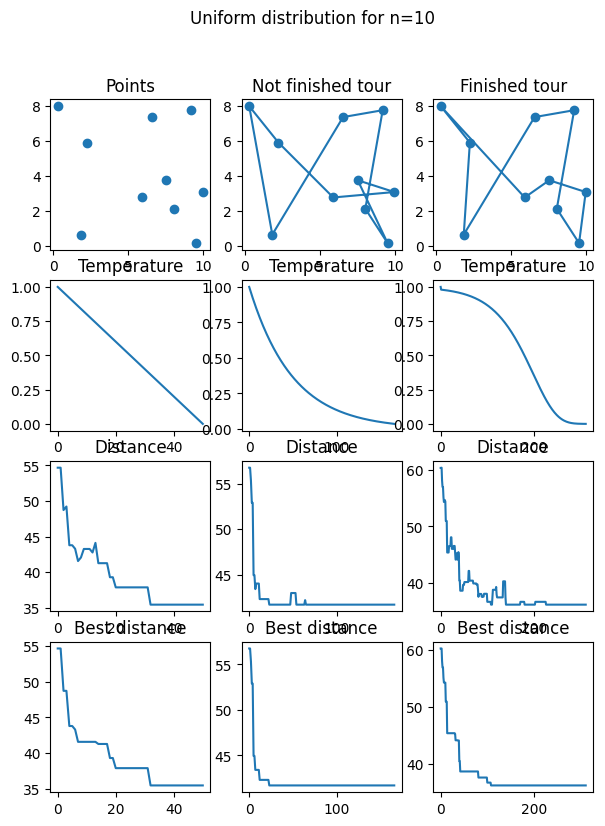

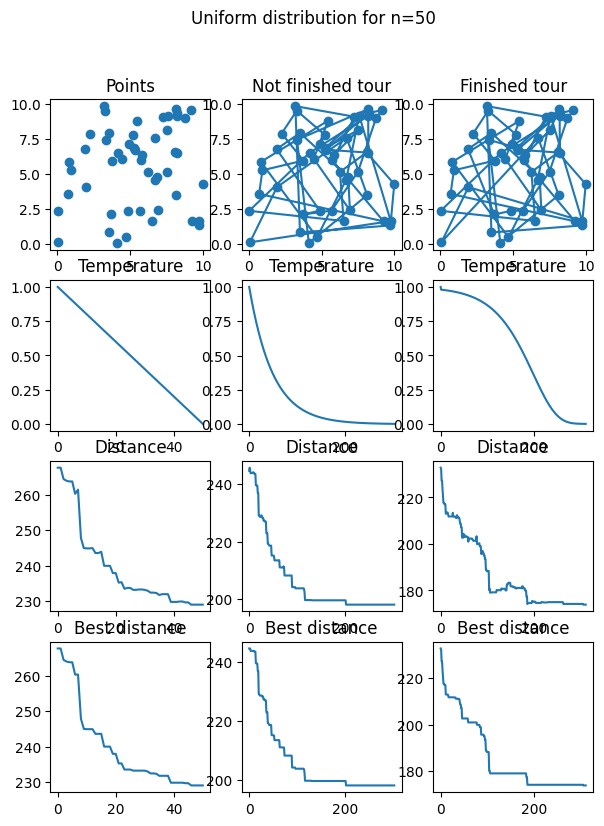

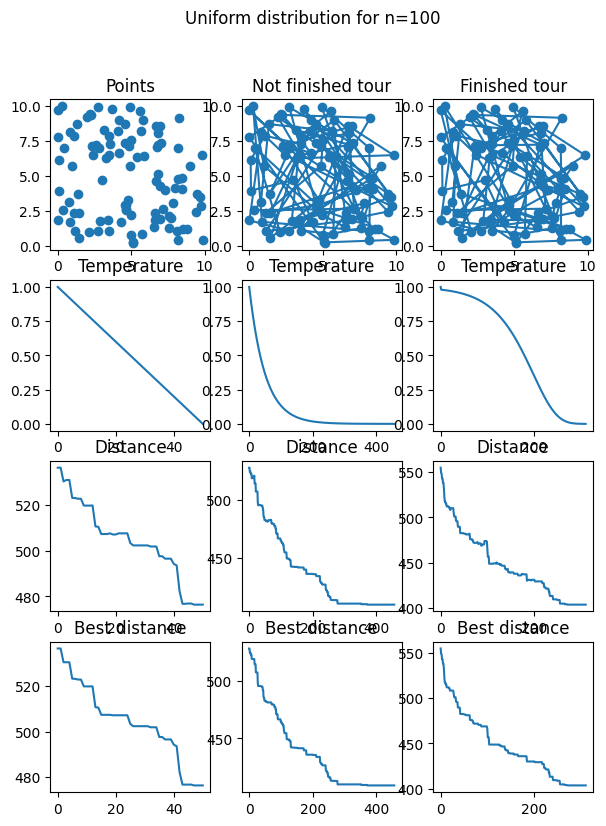

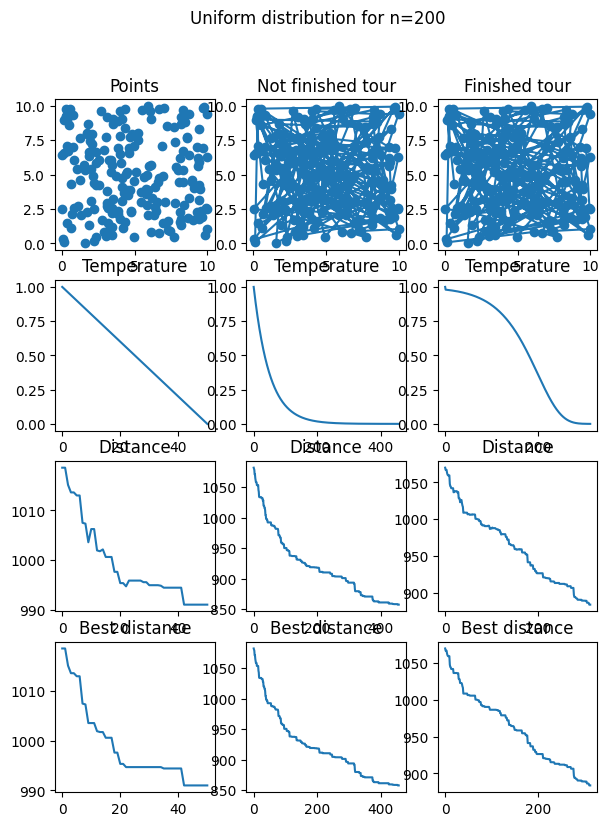

In [17]:
for p in uniform_arr:
    plot(p, f'Uniform distribution for n={p.shape[0]}', swap_func=consecutive_swap)

#### 7.1.2 Arbitrary swap

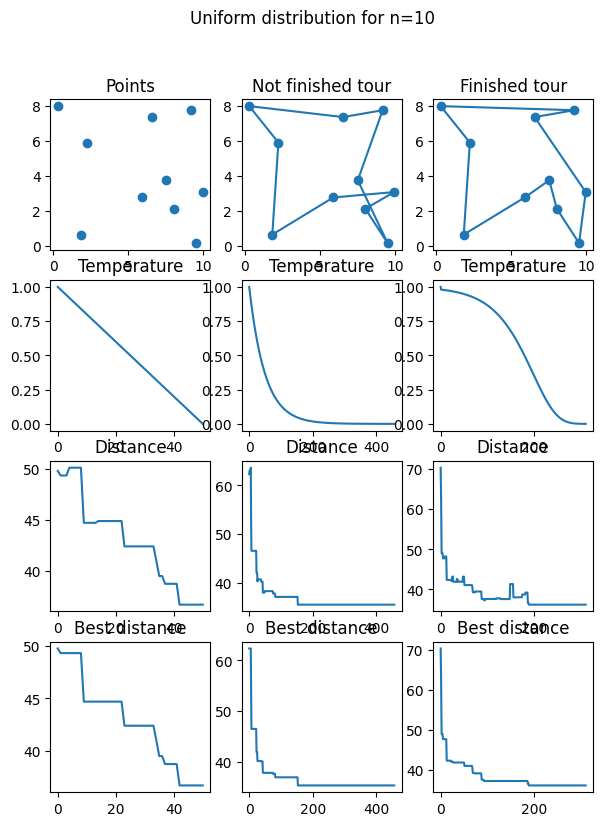

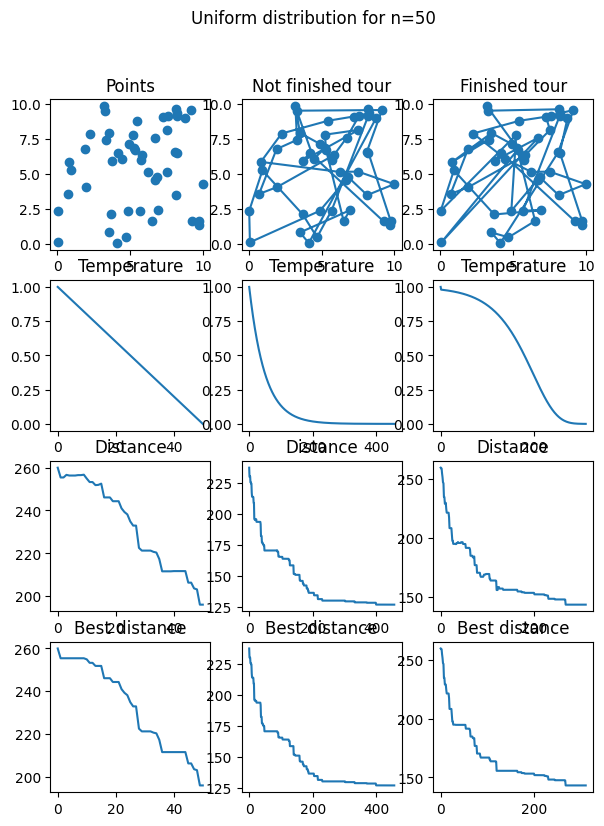

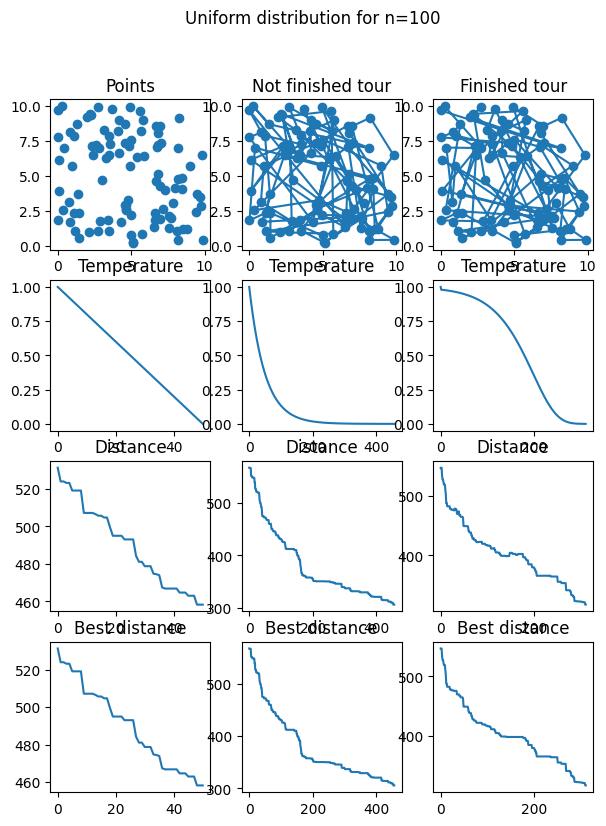

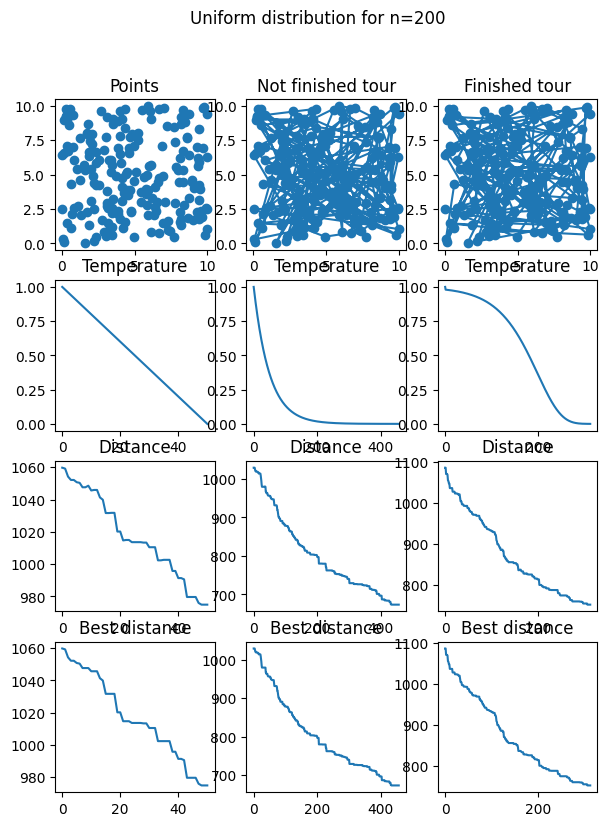

In [18]:
for p in uniform_arr:
    plot(p, f'Uniform distribution for n={p.shape[0]}', swap_func=arbitrary_swap)

### 7.2 4-groups distribution

#### 7.2.1 Consecutive swap

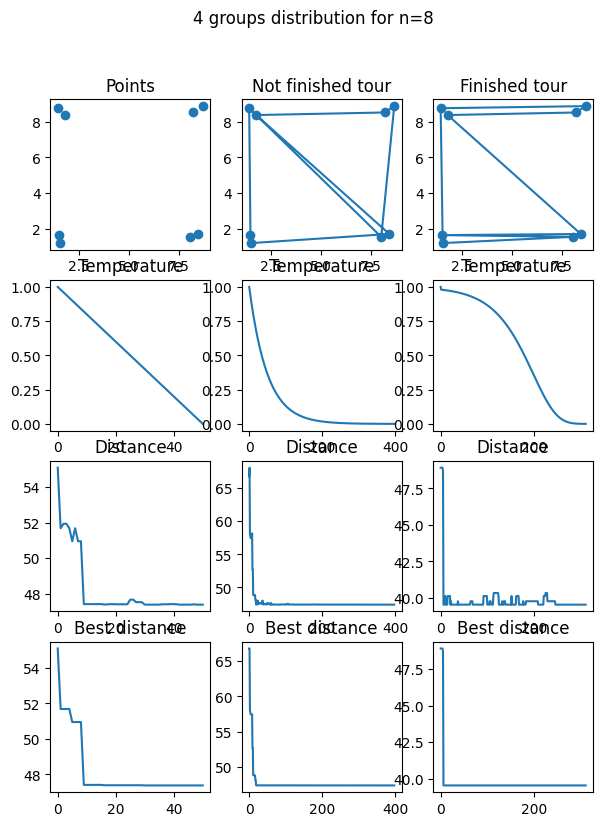

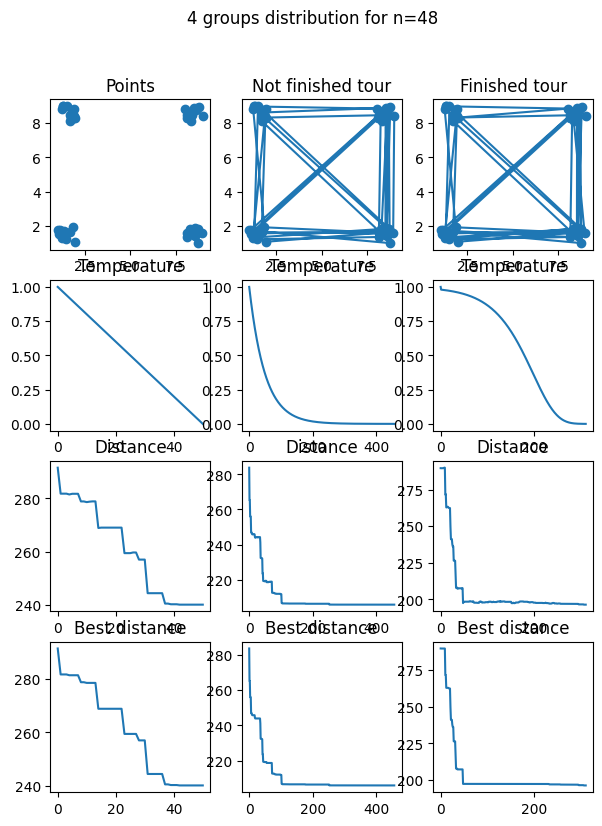

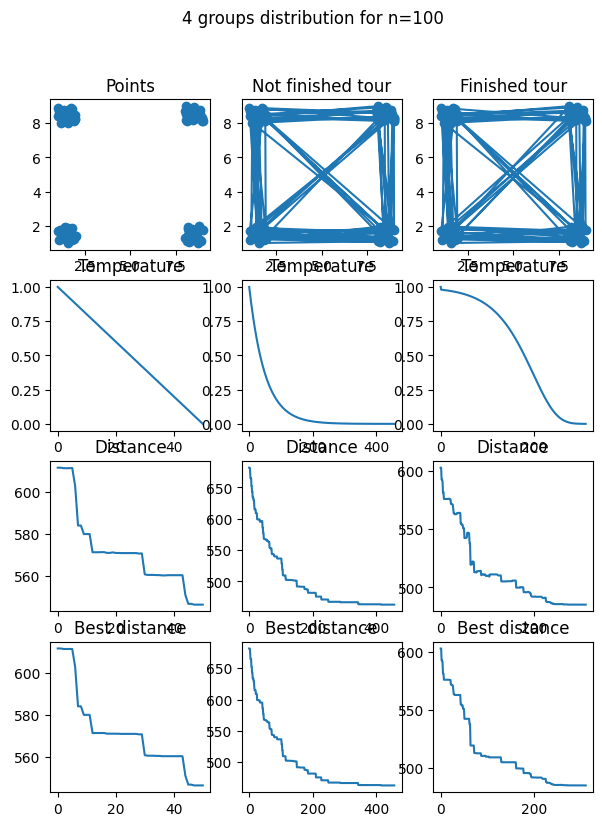

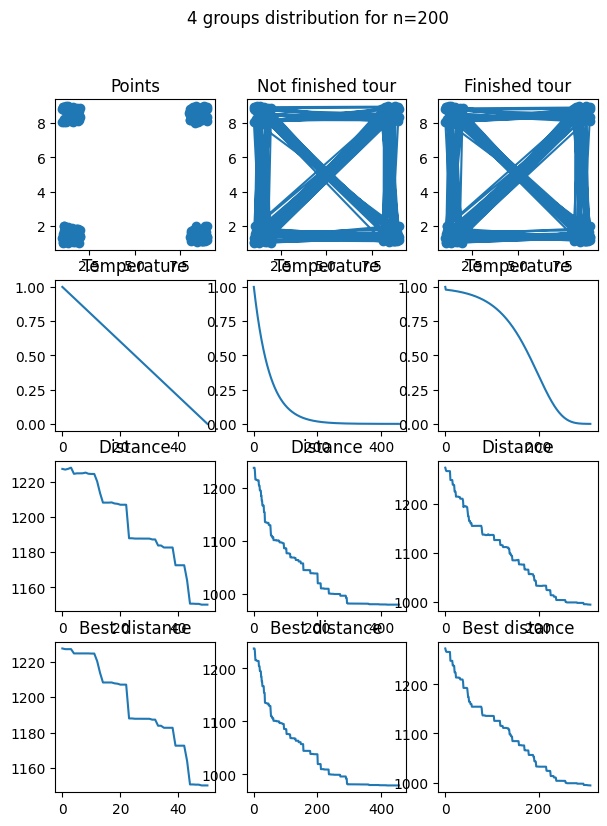

In [19]:
for p in groups4_arr:
    plot(p, f'4 groups distribution for n={p.shape[0]}', swap_func=consecutive_swap)

#### 7.2.2 Arbitrary swap

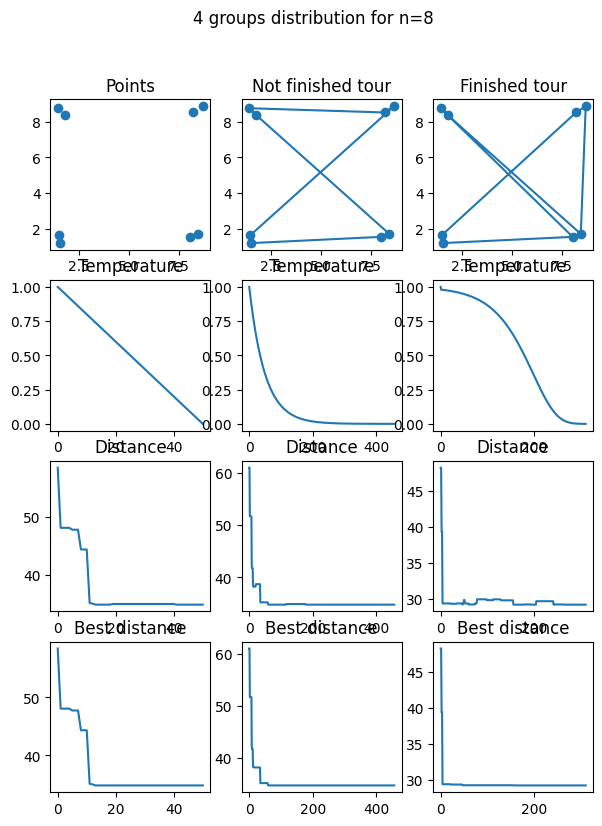

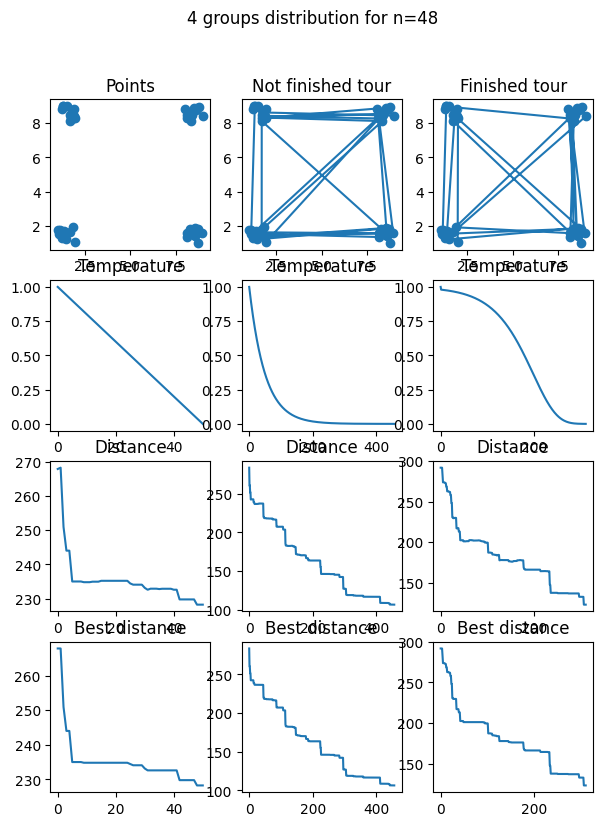

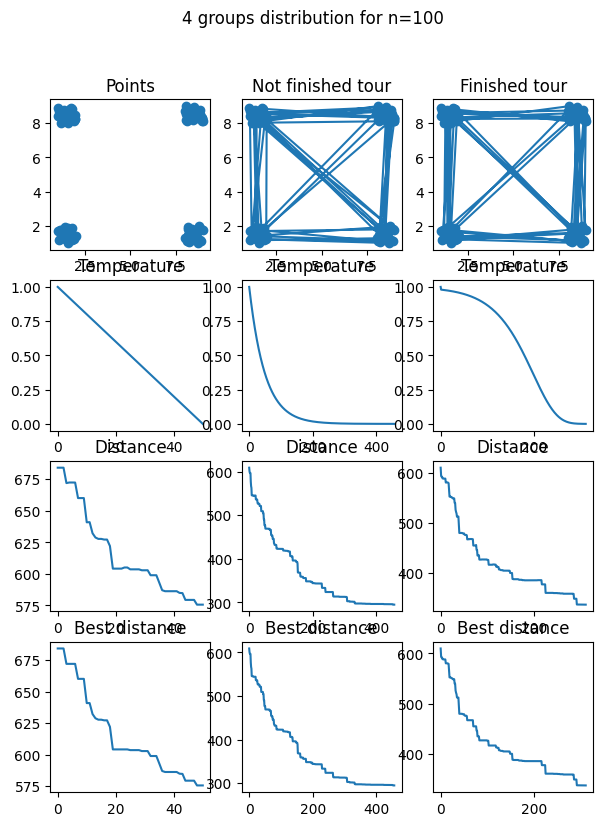

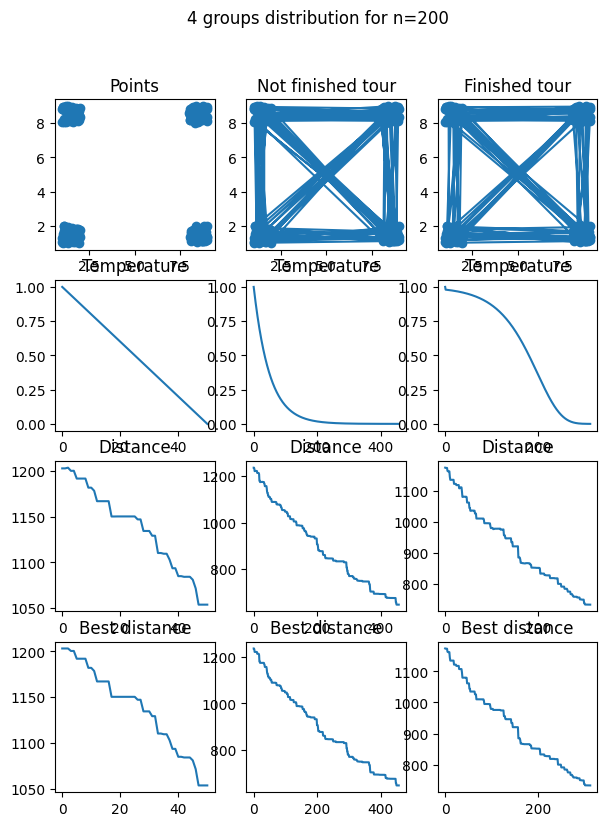

In [20]:
for p in groups4_arr:
    plot(p, f'4 groups distribution for n={p.shape[0]}', swap_func=arbitrary_swap)

### 7.3 9-groups distribution

#### 7.3.1 Consecutive swap

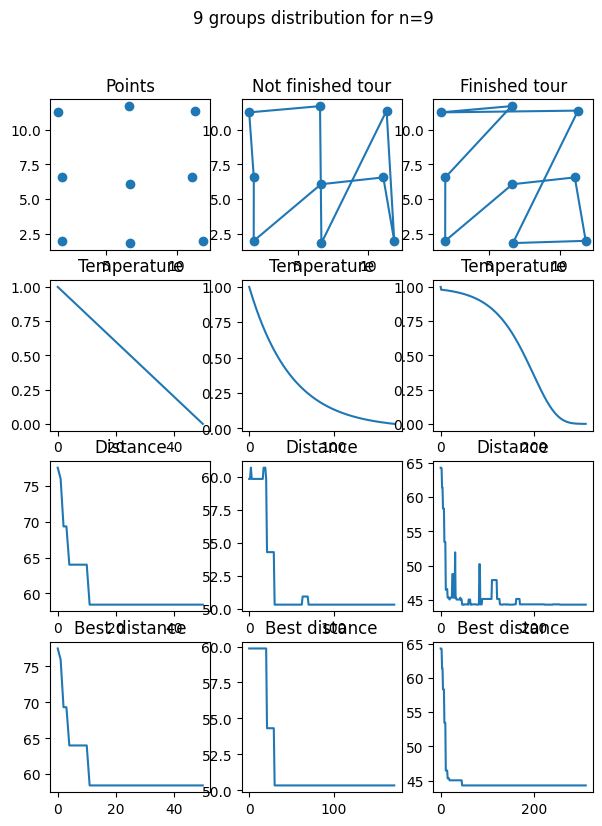

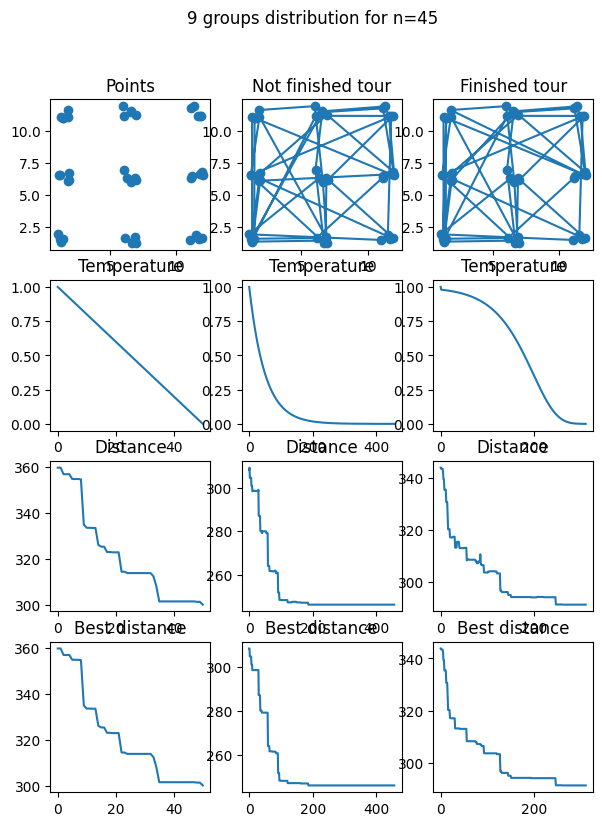

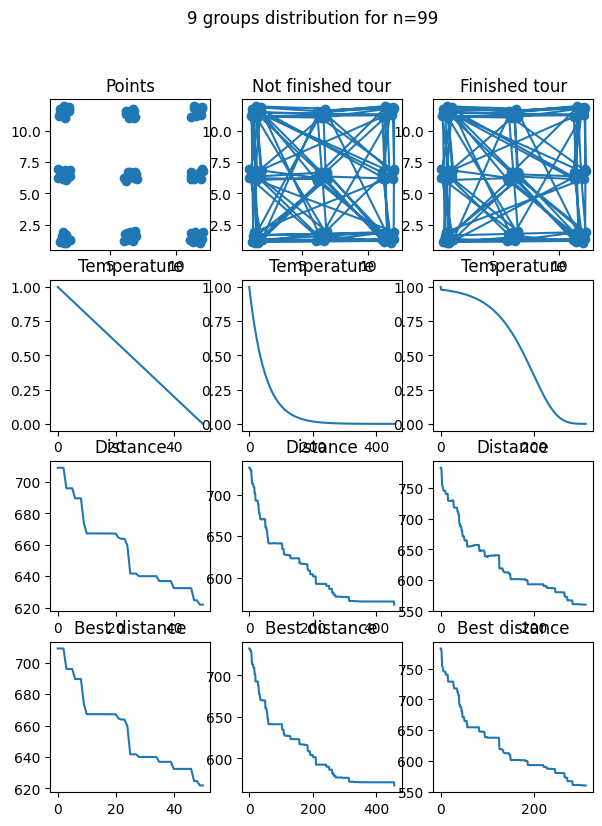

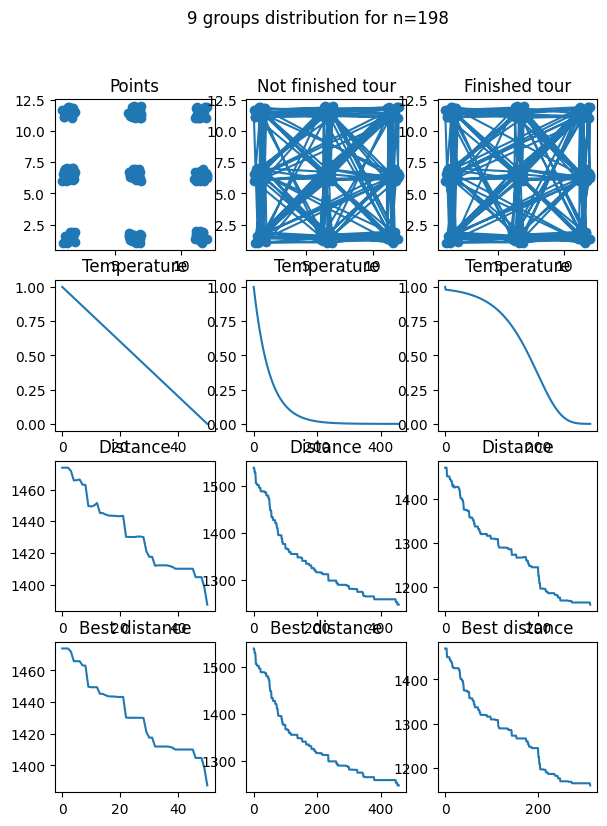

In [21]:
for p in groups9_arr:
    plot(p, f'9 groups distribution for n={p.shape[0]}', swap_func=consecutive_swap)

#### 7.3.2 Arbitrary swap

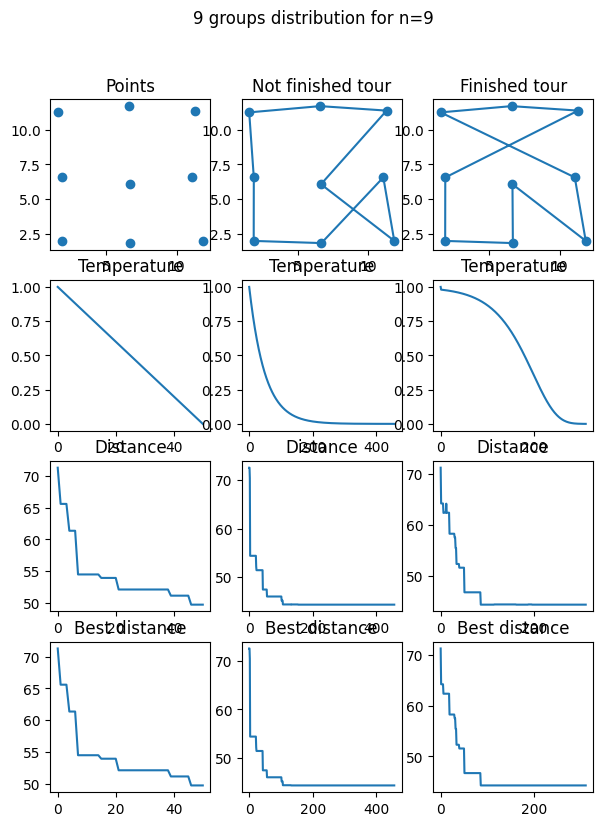

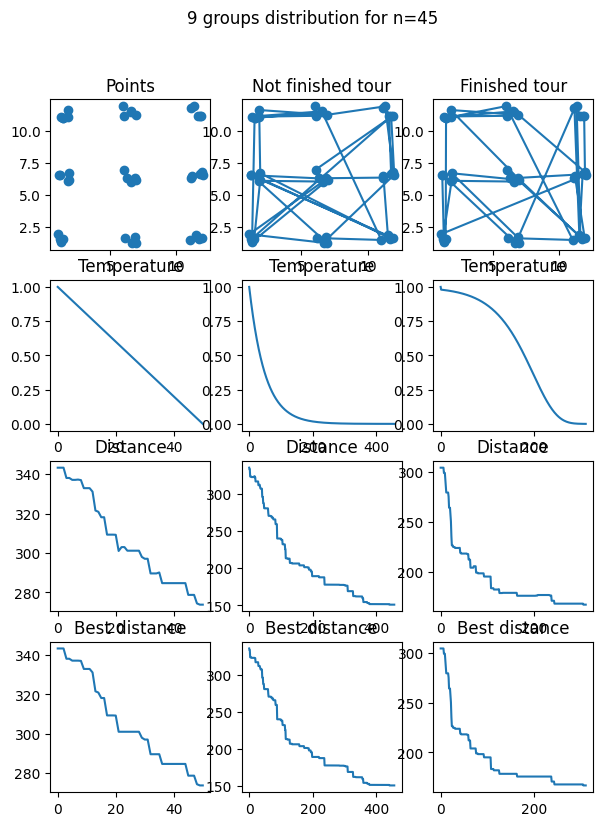

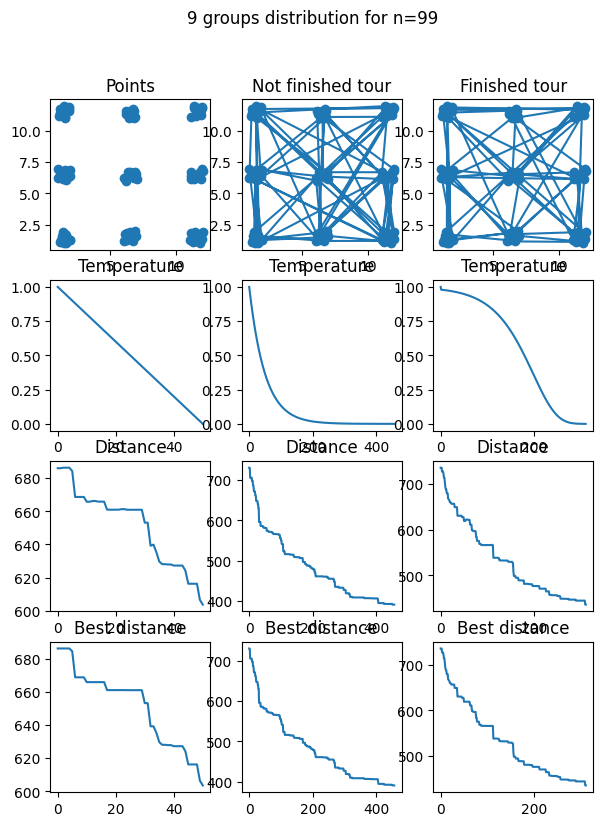

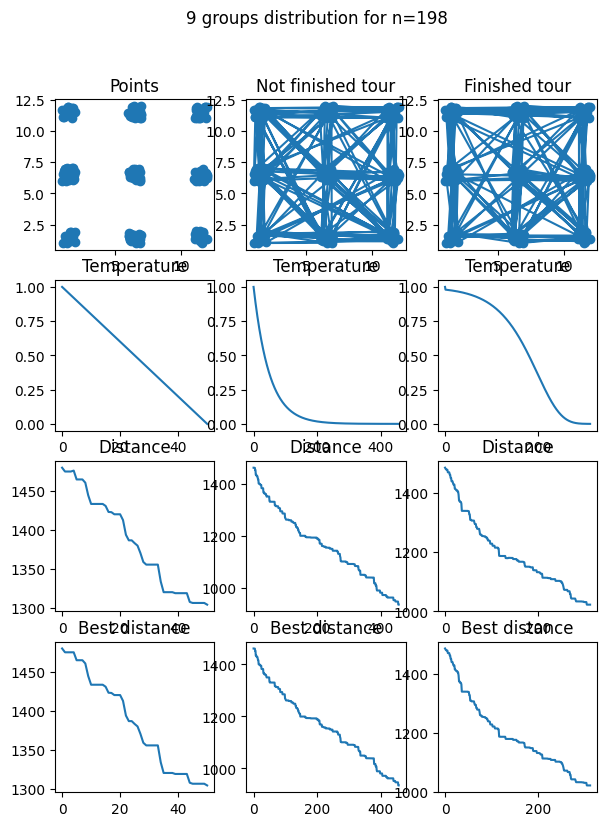

In [22]:
for p in groups9_arr:
    plot(p, f'9 groups distribution for n={p.shape[0]}', swap_func=arbitrary_swap)

---